# Content
Random forest classifier models of Dividing v. Differentiating cells
1. Model of birth frame
2. Model of mother division frame
3. Model of mother division frame - group 1diff and 2diff daughters
4. Model of mother division frame -12h

## 0. Load datasets

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection
from sklearn import ensemble, metrics, inspection

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    forests = []
    for i in tqdm(range(Niter)):
        
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs('Measurement',level=1,axis=1).astype(float)
        X = preprocessing.scale(X)
        
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = classifier.fit(X_train,y_train)
        forests.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),forests]
    

In [4]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    _df['Region'] = name
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}


In [5]:
len(all_tracks)

2323

### Isolate specific time points

In [6]:
df = all_df[all_df['Fate known','Meta']]
df = df[ ~df['Border','Meta'].astype(bool)]
df = df[ df['Cell type','Meta'] == 'Basal']
df['Cell growth smoothed specific growth rate','Meta'] = df['Cell volume smoothed growth rate','Measurement']/df['Cell volume smoothed','Measurement']
df['Nuclear growth smoothed specific growth rate','Meta'] = df['Nuclear volume smoothed growth rate','Measurement']/df['Nuclear volume smoothed','Measurement']

births = df[df['Birth frame','Meta']]
births_raw = births.copy()
print(f'Number of births: {len(births)}')

df = all_df[~np.isnan(all_df['Both daughters differentiated','Meta'].astype(float))]
df = df[ ~df['Border','Meta'].astype(bool)]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]].copy()
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index()
print(f'Number of mother divisions: {len(divisions)}')

prev_div_frame = [get_prev_or_next_frame(df,f,direction='prev') for _,f in divisions.iterrows()]
prev_div_frame = pd.concat(prev_div_frame,axis=1,ignore_index=False).T
#@todo: investigate efficiency of force-casting at different points
for col in df.columns:
    prev_div_frame[col] = prev_div_frame[col].astype(df[col].dtype)
prev_div_frame = prev_div_frame[~prev_div_frame['Border','Meta'].astype(bool)]
prev_div_frame = prev_div_frame.reset_index().rename(columns={'level_0':'Frame','level_1':'TrackID'}).set_index('TrackID')
print(f'Number of 12h prior to divisions: {len(prev_div_frame)}')

prev2_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev', increment=2) for _,f in divisions.iterrows()]
prev2_div_frame = pd.concat(prev2_div_frame,axis=1).T
prev2_div_frame = prev2_div_frame[~prev2_div_frame['Border','Meta'].astype(bool)]
for col in df.columns:
    prev2_div_frame[col] = prev2_div_frame[col].astype(df[col].dtype)
print(f'Number of 24h prior to divisions: {len(prev2_div_frame)}')

prev3_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev', increment=3) for _,f in divisions.iterrows()]
prev3_div_frame = pd.concat(prev3_div_frame,axis=1).T
prev3_div_frame = prev3_div_frame[~prev3_div_frame['Border','Meta'].astype(bool)]
for col in df.columns:
    prev3_div_frame[col] = prev3_div_frame[col].astype(df[col].dtype)
print(f'Number of 36h prior to divisions: {len(prev3_div_frame)}')

prev4_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev', increment=4) for _,f in divisions.iterrows()]
prev4_div_frame = pd.concat(prev4_div_frame,axis=1).T
prev4_div_frame = prev4_div_frame[~prev4_div_frame['Border','Meta'].astype(bool)]
for col in df.columns:
    prev4_div_frame[col] = prev4_div_frame[col].astype(df[col].dtype)
print(f'Number of 48h prior to divisions: {len(prev4_div_frame)}')


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69556/328864670.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Cell growth smoothed specific growth rate','Meta'] = df['Cell volume smoothed growth rate','Measurement']/df['Cell volume smoothed','Measurement']
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69556/328864670.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Nuclear growth smoothed specific growth rate','Meta'] = df['Nuclear volume smoothed growth rate','Measurement']/df['Nuclear v

Number of births: 764
Number of mother divisions: 307
Number of 12h prior to divisions: 243
Number of 24h prior to divisions: 206
Number of 36h prior to divisions: 157
Number of 48h prior to divisions: 115


#### Filter out features

Manually censor some features

In [7]:
# Censor age / time til diff
features2drop = [f for f in births.columns.get_level_values(0) if 'Time to differentiation' in f]
features2drop += [f for f in births.columns.get_level_values(0) if 'Age' in f]
# Censor height information
features2drop = features2drop + ['Z','Mean curvature - cell coords','Z-cyto','Height to BM','Height to BM at 1 frame prior',
                                 'Basal area','Apical area','Relative Height to BM','Relative Height to BM at 1 frame prior']
# Censor all exponential rates (but not mother's)
features2drop = features2drop + [f for f in births.columns.get_level_values(0)
                                 if ('exponential' in f and 'frame prior' not in f \
                                         and 'G1' not in f)]

np.isnan(births['Cell volume G1 only exponential growth rate']).sum()

Metadata
Measurement    348
dtype: int64

Manage the feature names

In [8]:
metas = pd.DataFrame()
metas['name'] = births.xs('Meta',level=1,axis=1).columns
features = pd.DataFrame()

measurements = births.xs('Measurement',level=1,axis=1)
features['name'] = measurements.columns
features =features.set_index('name')
features['Num NA'] = measurements.isna().sum(axis=0)
feature_names = features.index
num_nas = (features['Num NA'] > 0).sum()

# print(f'Number of features with NAs: {num_nas}')
# print(features.sort_values('Num NA').tail(50))

# Set the acceptable number of NAs (will be dropped)
na_thresh = 350
features2drop += features[features['Num NA'] > na_thresh].index.values.tolist()

births = births.drop(columns=features2drop)
divisions = divisions.drop(columns=features2drop)
prev_div_frame = prev_div_frame.drop(columns=features2drop)
prev2_div_frame = prev2_div_frame.drop(columns=features2drop)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69556/2971050117.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  births = births.drop(columns=features2drop)
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69556/2971050117.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  divisions = divisions.drop(columns=features2drop)
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69556/2971050117.py:21: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  prev_div_frame = prev_div_frame.drop(columns=features2drop)
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69556/2971050117.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  prev2_div_frame = prev2_div_frame.drop(columns=features2drop)


In [9]:
# Drop the NA samples and update the leftover features list

births = births.dropna(axis=0,subset=[(a,b) for (a,b) in births.columns if b == 'Measurement'], how='any')
divisions = divisions.dropna(axis=1)
prev_div_frame = prev_div_frame.dropna(axis=1)
prev2_div_frame = prev2_div_frame.dropna(axis=1)

print('---')
print(f'Number of births: {len(births)}')
print(f'Number of mother divisions: {len(divisions)}')
print(f'Number of 12h prior to divisions: {len(prev_div_frame)}')
print(f'Number of 24h prior to divisions: {len(prev2_div_frame)}')

print('---')
print(f'Births: {len(births.columns)} features')
print(f'Mother divisions: {len(divisions.columns)} features')
print(f'12h prior to divisions: {len(prev_div_frame.columns)} features')
print(f'24h prior to divisions: {len(prev2_div_frame.columns)} features')

birth_feature_set = births.xs('Measurement',level=1,axis=1).columns
conservative_feature_set = prev2_div_frame.xs('Measurement',level=1,axis=1).columns
assert(np.isnan(births[conservative_feature_set]).values.sum() == 0)
assert(np.isnan(divisions[conservative_feature_set]).values.sum() == 0)
assert(np.isnan(prev_div_frame[conservative_feature_set]).values.sum() == 0)
assert(np.isnan(prev2_div_frame[conservative_feature_set]).values.sum() == 0)

---
Number of births: 366
Number of mother divisions: 307
Number of 12h prior to divisions: 243
Number of 24h prior to divisions: 206
---
Births: 1361 features
Mother divisions: 781 features
12h prior to divisions: 779 features
24h prior to divisions: 778 features


## 1. Categorize cell from its birth frame
### Categorize will differentiate v. will divide

In [10]:
# Run classifier
# axis0: observation axis1: prediction

feature2predict = 'Will differentiate'
predictions,models = predict_feature(births, ensemble.RandomForestClassifier(), feature2predict)

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Text(0.5, 0, 'AUCs')

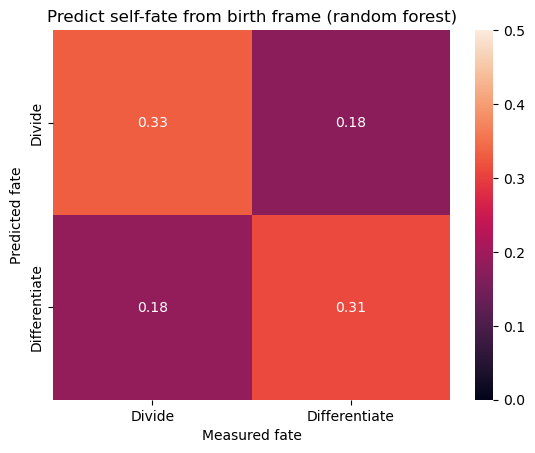

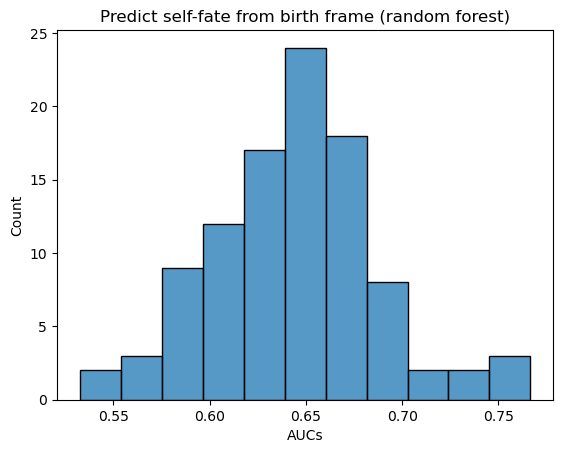

In [11]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict self-fate from birth frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict self-fate from birth frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')

### Plot the impurity importances

Text(0, 0.5, 'Impurity importance')

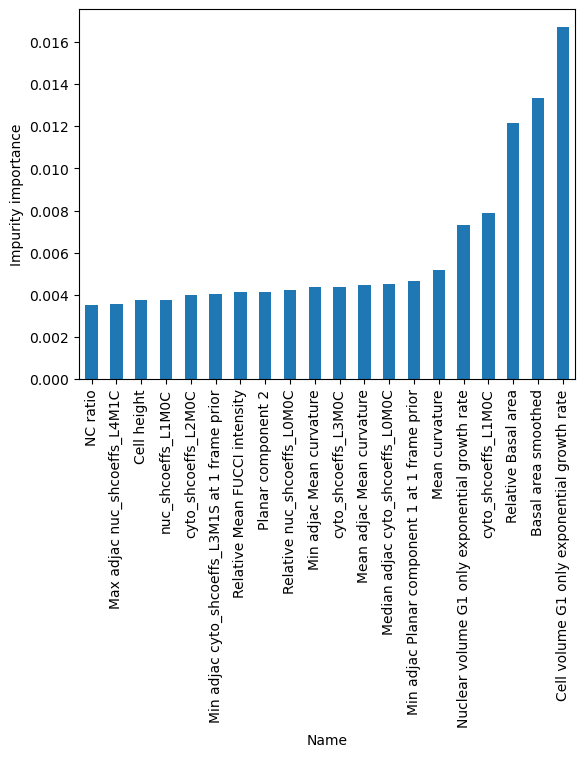

In [12]:
importances = pd.DataFrame([m.feature_importances_ for m in models],columns=birth_feature_set)
importances.mean(axis=0).sort_values().tail(20).plot.bar()

plt.ylabel('Impurity importance')

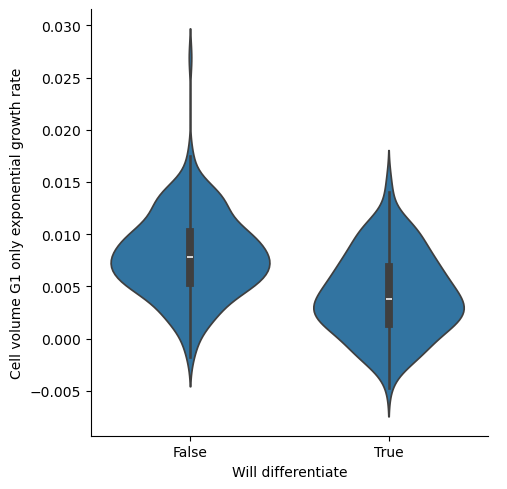

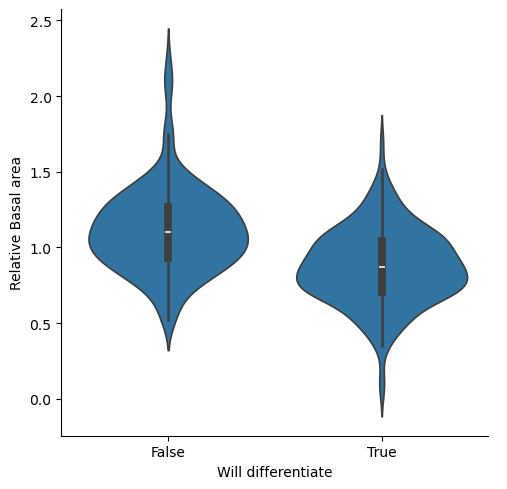

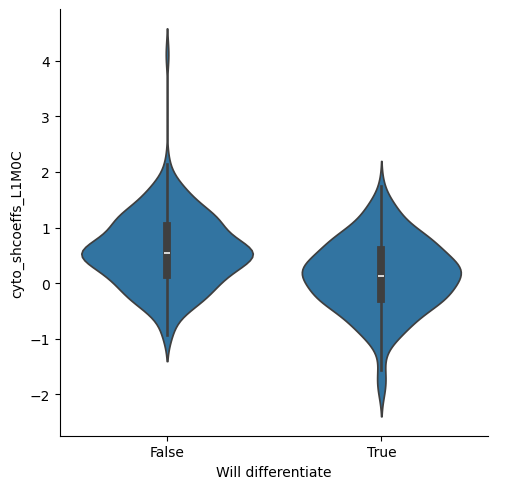

In [15]:
sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Cell volume G1 only exponential growth rate',kind='violin')
sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Relative Basal area',kind='violin')
sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='cyto_shcoeffs_L1M0C',kind='violin')

## 2. Predict from mother division frame

In [21]:
# Run classifier
# axis0: observation axis1: prediction

feature2predict = 'At least one daughter differentiated'
predictions,models = predict_feature(divisions, ensemble.RandomForestClassifier(), feature2predict)


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.95it/s]


Text(0.5, 0, 'AUCs')

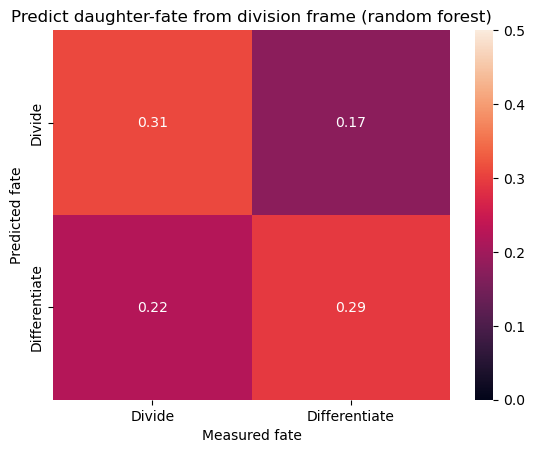

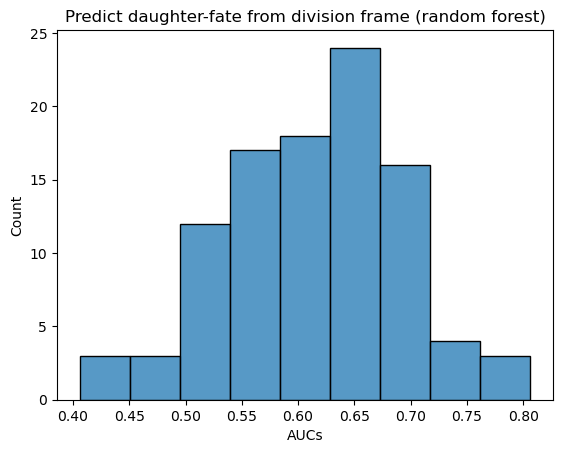

In [22]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')


Text(0, 0.5, 'Impurity importance')

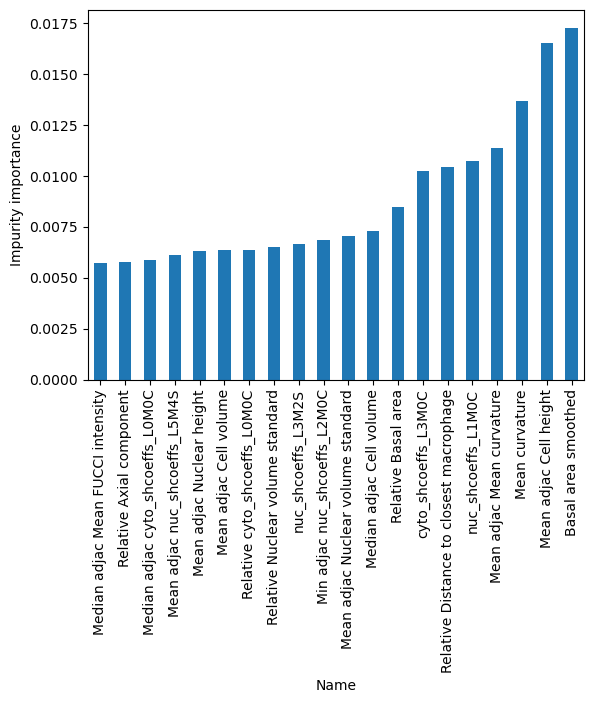

In [23]:
importances = pd.DataFrame([m.feature_importances_ for m in models],
                           columns=divisions.xs('Measurement',level=1,axis=1).columns)
importances.mean(axis=0).sort_values().tail(20).plot.bar()

plt.ylabel('Impurity importance')

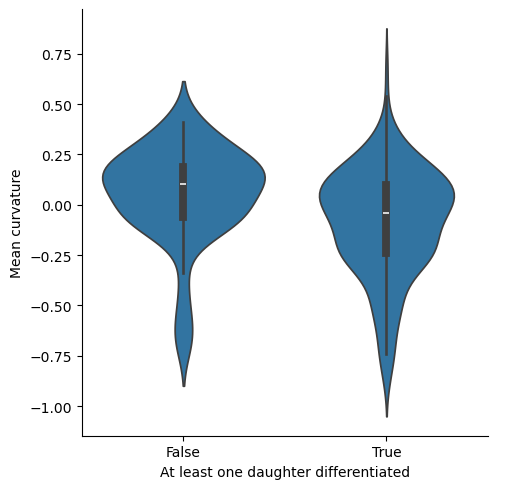

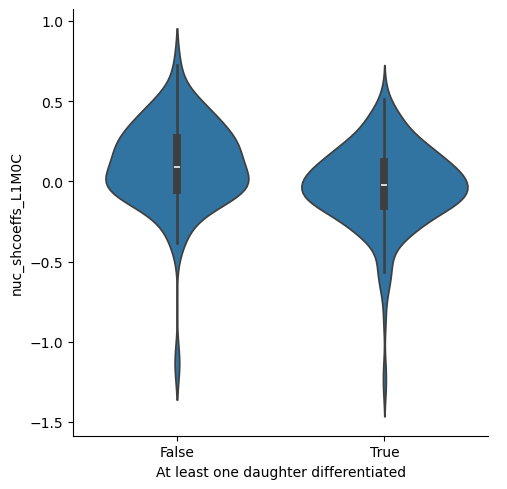

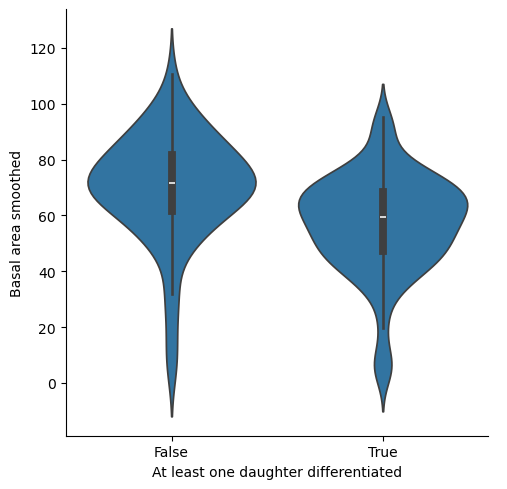

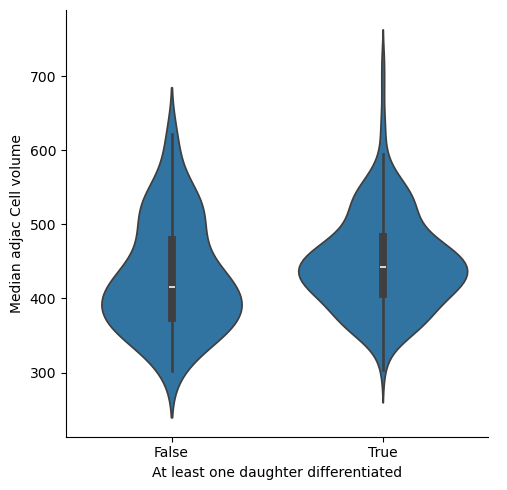

In [26]:
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Mean curvature',kind='violin')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='nuc_shcoeffs_L1M0C',kind='violin')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Basal area smoothed',kind='violin')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Median adjac Cell volume',kind='violin')

## 3. Predict from mother division -12h

In [27]:
# Run classifier
# axis0: observation axis1: prediction

feature2predict = 'At least one daughter differentiated'
predictions,models = predict_feature(prev_div_frame, ensemble.RandomForestClassifier(), feature2predict)


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.21it/s]


Text(0.5, 0, 'AUCs')

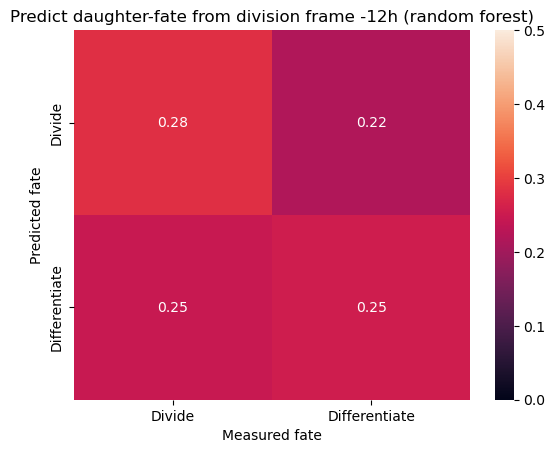

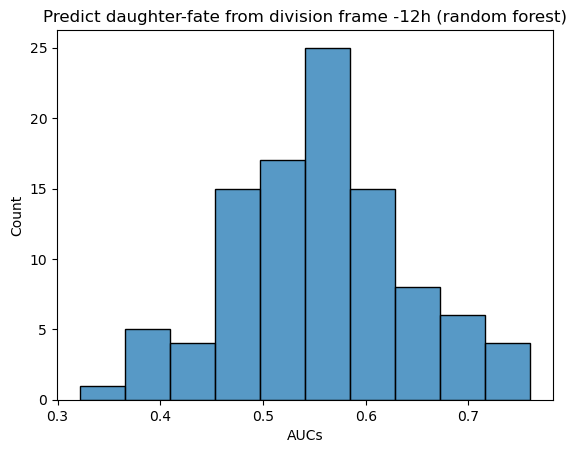

In [28]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict daughter-fate from division frame -12h (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame -12h (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')


Text(0, 0.5, 'Impurity importance')

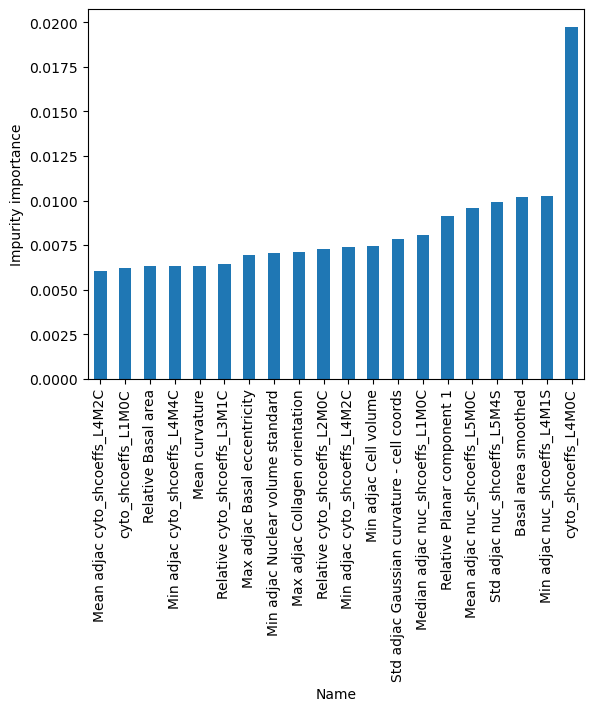

In [29]:
importances = pd.DataFrame([m.feature_importances_ for m in models],
                           columns=divisions.xs('Measurement',level=1,axis=1).columns)
importances.mean(axis=0).sort_values().tail(20).plot.bar()

plt.ylabel('Impurity importance')


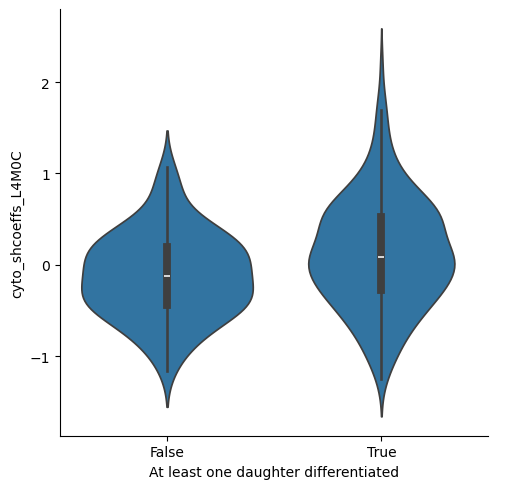

In [32]:
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='cyto_shcoeffs_L4M0C',kind='violin')


## 4. Predict from mother division -24h

In [33]:
# Run classifier
# axis0: observation axis1: prediction

feature2predict = 'At least one daughter differentiated'
predictions,models = predict_feature(prev2_div_frame, ensemble.RandomForestClassifier(), feature2predict)


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.21it/s]


Text(0.5, 0, 'AUCs')

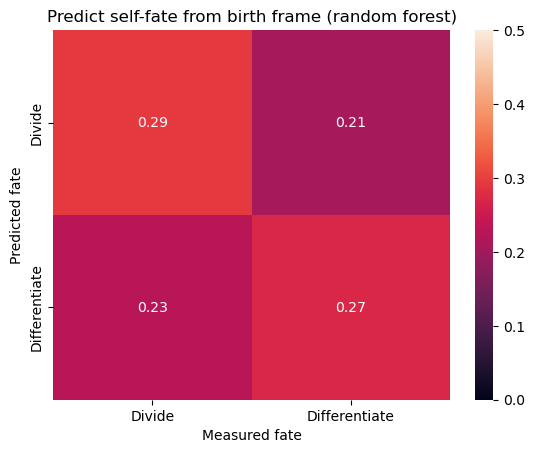

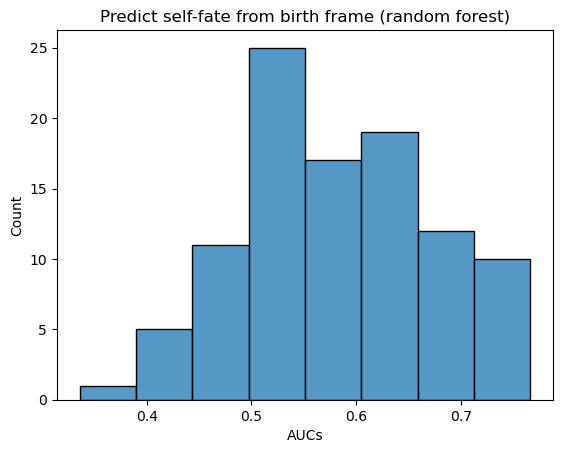

In [34]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict self-fate from birth frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict self-fate from birth frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')


Text(0, 0.5, 'Impurity importance')

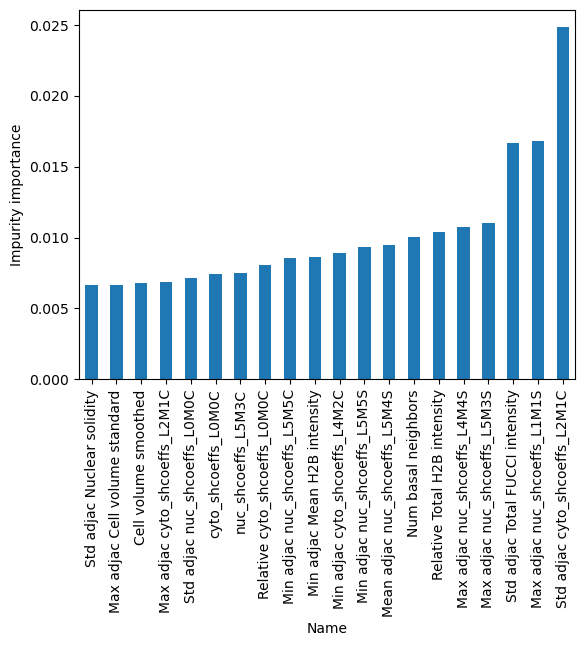

In [35]:
importances = pd.DataFrame([m.feature_importances_ for m in models],
                           columns=divisions.xs('Measurement',level=1,axis=1).columns)
importances.mean(axis=0).sort_values().tail(20).plot.bar()

plt.ylabel('Impurity importance')


## 5. Prediction going back in time

In [36]:
# Subsample
print(f'Num births: {len(births)}')
print(f'Num division 36h prior: {len(prev3_div_frame)}')
Nsubsample = len(prev3_div_frame)

Num births: 366
Num division 36h prior: 157


In [37]:
# Run classifier with conservatived feature set
# axis0: observation axis1: prediction

AUCs = pd.DataFrame()
importances = pd.DataFrame(columns=conservative_feature_set)
# Self
feature2predict = 'Will differentiate'
cols2keep = [(f,'Measurement') for f in conservative_feature_set]
cols2keep += [(feature2predict,'Meta')]
predictions,models = predict_feature(births[cols2keep], ensemble.RandomForestClassifier(), feature2predict, subsample=Nsubsample)
auc = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
AUCs.loc['Birth','Mean'] = auc.mean()
AUCs.loc['Birth','Std'] = auc.std()
importances.loc['Birth',:] = \
    pd.DataFrame([m.feature_importances_ for m in models],columns=conservative_feature_set).mean(axis=0)

# Mother
feature2predict = 'At least one daughter differentiated'
cols2keep = [(f,'Measurement') for f in conservative_feature_set]
cols2keep += [(feature2predict,'Meta')]
predictions,models = predict_feature(divisions[cols2keep], ensemble.RandomForestClassifier(), feature2predict, subsample=Nsubsample)
auc = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
AUCs.loc['Mother div','Mean'] = auc.mean()
AUCs.loc['Mother div','Std'] = auc.std()
importances.loc['Mother div',:] = \
    pd.DataFrame([m.feature_importances_ for m in models],columns=conservative_feature_set).mean(axis=0)

# Mother -12h
feature2predict = 'At least one daughter differentiated'
cols2keep = [(f,'Measurement') for f in conservative_feature_set]
cols2keep += [(feature2predict,'Meta')]
predictions,models = predict_feature(prev_div_frame[cols2keep], ensemble.RandomForestClassifier(), feature2predict, subsample=Nsubsample)
auc = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
AUCs.loc['Mother div -12h','Mean'] = auc.mean()
AUCs.loc['Mother div -12h','Std'] = auc.std()
importances.loc['Mother div -12h',:] = \
    pd.DataFrame([m.feature_importances_ for m in models],columns=conservative_feature_set).mean(axis=0)

# Mother -24h
feature2predict = 'At least one daughter differentiated'
cols2keep = [(f,'Measurement') for f in conservative_feature_set]
cols2keep += [(feature2predict,'Meta')]
predictions,models = predict_feature(prev2_div_frame[cols2keep], ensemble.RandomForestClassifier(), feature2predict, subsample=Nsubsample)
auc = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
AUCs.loc['Mother div -24h','Mean'] = auc.mean()
AUCs.loc['Mother div -24h','Std'] = auc.std()
importances.loc['Mother div -24h',:] = \
    pd.DataFrame([m.feature_importances_ for m in models],columns=conservative_feature_set).mean(axis=0)

# Mother -36h
feature2predict = 'At least one daughter differentiated'
cols2keep = [(f,'Measurement') for f in conservative_feature_set]
cols2keep += [(feature2predict,'Meta')]
predictions,models = predict_feature(prev3_div_frame[cols2keep], ensemble.RandomForestClassifier(), feature2predict)
auc = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
AUCs.loc['Mother div -36h','Mean'] = auc.mean()
AUCs.loc['Mother div -36h','Std'] = auc.std()
importances.loc['Mother div -24h',:] = \
    pd.DataFrame([m.feature_importances_ for m in models],columns=conservative_feature_set).mean(axis=0)

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.24it/s]


Text(0, 0.5, 'Predictive accuracy (AUC of ROC)')

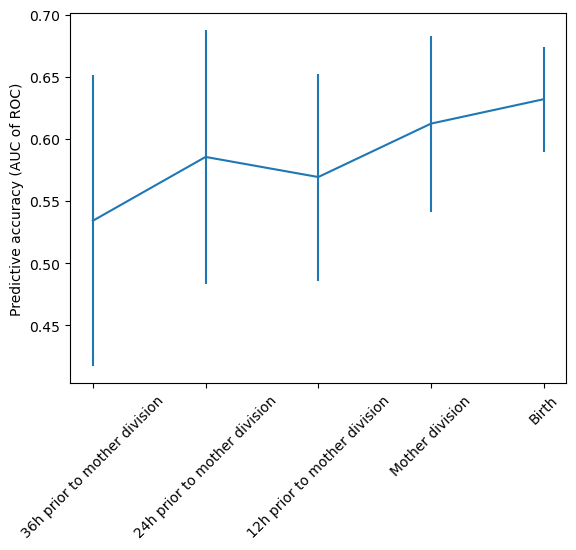

In [41]:
plt.errorbar(x=range(5),y=AUCs['Mean'][::-1],yerr=(AUCs['Std'])[::-1])
plt.gca().set_xticks([0,1,2,3,4],labels=['36h prior to mother division',
                                         '24h prior to mother division',
                                         '12h prior to mother division',
                                         'Mother division',
                                         'Birth'],rotation=45)
plt.ylabel('Predictive accuracy (AUC of ROC)')

In [603]:
conservative_feature_set

Index(['Nuclear volume', 'Nuclear solidity', 'Y', 'X', 'Nuclear height',
       'Cell volume', 'Y-cyto', 'X-cyto', 'Axial component',
       'Planar component 1',
       ...
       'Relative nuc_shcoeffs_L4M4S', 'Relative nuc_shcoeffs_L5M1S',
       'Relative nuc_shcoeffs_L5M2S', 'Relative nuc_shcoeffs_L5M3S',
       'Relative nuc_shcoeffs_L5M4S', 'Relative nuc_shcoeffs_L5M5S',
       'Relative nuc_shcoeffs_surface_area',
       'Relative Distance to closest macrophage',
       'Relative Nuclear volume standard', 'Relative Cell volume standard'],
      dtype='object', name='Name', length=753)

<Axes: >

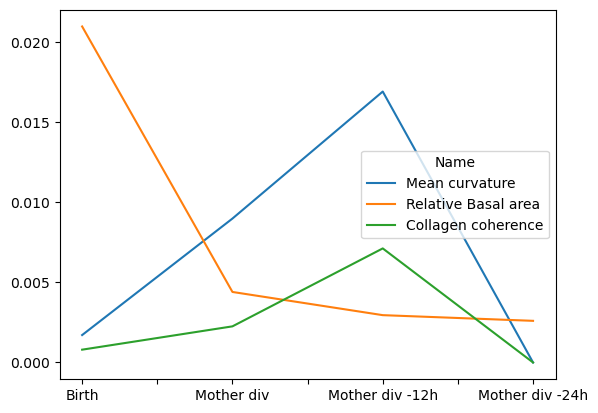

In [48]:
# Time course of importances of key features (motivated by RFE)
features2plot = [
    'Mean curvature',
    'Relative Basal area',
    'Collagen coherence',
]
importances[features2plot].plot()

## Misc: visualizations

<Figure size 640x480 with 0 Axes>

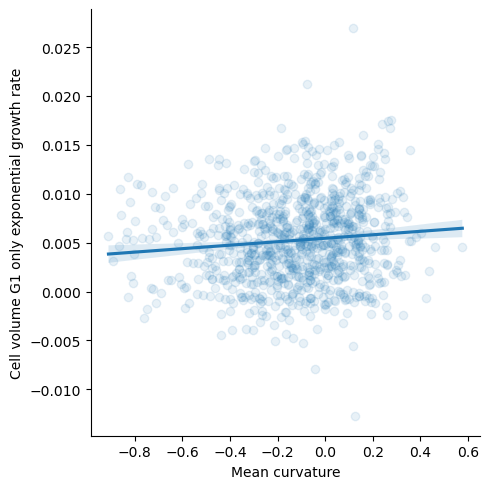

<Figure size 640x480 with 0 Axes>

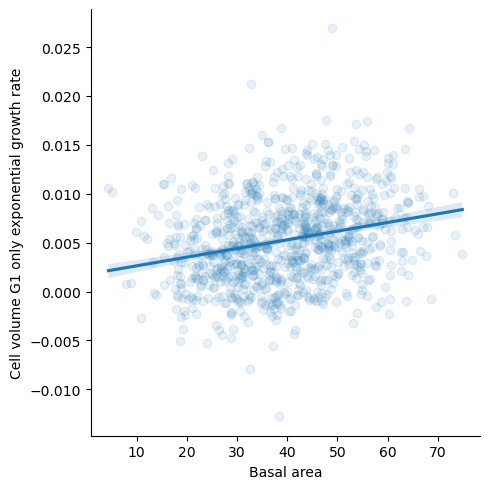

In [539]:
plt.figure()
x = 'Mean curvature'
y = 'Cell volume G1 only exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1})

plt.figure()
x = 'Basal area'
y = 'Cell volume G1 only exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1}, fit_reg=True)

In [227]:
features2drop = [f for f in all_df.droplevel(axis=1,level=1).columns if 'smoothed' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'shcoeffs' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'prior' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'standard' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'BM' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'intensity' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'Time' in f]
A = all_df.droplevel(axis=1,level=1).drop(
    columns=['X','X-pixels','Y','Y-pixels','X-cyto','Y-cyto','Z','Z-cyto',
             'Daughter a','Daughter b','Mother','Sister']+features2drop).select_dtypes(numerics).corr(numeric_only=True)

B = A.abs().unstack().sort_values(ascending=False)

unique_pairs = []
# Iterate over the top pairs and add only unique pairs to the list
for pair in B.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# Create a dataframe with the top pairs and their correlation coefficients
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    corr_df.loc[i] = [pair[0], pair[1], B.loc[pair[0], pair[1]]]

display(corr_df.dropna().head(50))


,feature_1,feature_2,corr_coef
0,Nuclear bbox bottom,Nuclear bbox top,0.979166
1,Nuclear volume exponential growth rate,Nuclear volume (filter_name) exponential growt...,0.919772
2,Cell volume exponential growth rate,Cell volume (filter_name) exponential growth rate,0.904737
3,Planar component 2,Planar component 1,0.823052
4,Axial component,Middle area,0.747579
5,Right,Left,0.747405
6,Mean curvature - cell coords,Nuclear bbox bottom,0.742856
7,Nuclear volume,Cell volume,0.731716
8,Nuclear bbox top,Mean curvature - cell coords,0.714124
9,Cell height,Planar component 1,0.693165
